***overview of the steps the code will perform:***


1.   Install necessary libraries and import required modules.
1.   Download and unzip the dataset.
1.   Define the display_top5_predictions function to display top-5 predictions for randomly selected images from a given dataset.
1.   Define data pre-processing using torchvision transforms.
1.   Load the dataset using the ImageFolder function for the train, validation, and test datasets.
1.   Perform a grid search for hyperparameters by iterating through different combinations of batch sizes, learning rates, optimizers, and loss functions.
1.   Instantiate the model (ResNet34), optimizer, and loss function for the current configuration.
1.   Train the model for the specified number of epochs.
1.   Define the evaluate function to calculate the accuracy of the model on a given dataset.
1.   Calculate the validation and test accuracies.
1.   Define the topk_accuracy function to calculate top-1 and top-5 accuracies for a given dataset.
1.   Calculate top-1 and top-5 accuracies for the validation and test datasets.
1.   Define the get_predictions and get_images_predictions functions to get true labels and predictions for a given dataset.
1.   Get true labels and predictions for the validation and test datasets.
1.   Calculate confusion matrices for the validation and test datasets.
1.   Define the display_confusion_matrix function to display the confusion matrix.
1.   Display top-5 predictions for randomly selected images from the validation and test datasets.
1.   Display confusion matrices for the validation and test datasets.
1.   Save the trained model.
1.   Download the saved model file to your local machine. 
1.   Download the saved model file to your local machine.






In [7]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
class Places2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.categories = []
        self.images = []
        self.labels = []
        
        for root, dirs, files in os.walk(root_dir):
            if not dirs:
                category_name = os.path.basename(root)
                if category_name not in self.categories:
                    self.categories.append(category_name)
                category_idx = self.categories.index(category_name)
                for image_file in files:
                    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(root, image_file))
                        self.labels.append(category_idx)
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations to apply on the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [9]:
!unzip -o "/content/drive/MyDrive/Places2_simp.zip" -d "/content/"
!unzip -o "/content/drive/MyDrive/testset.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Places2_simp/phone_booth/00000936.jpg  
  inflating: /content/Places2_simp/phone_booth/00000739.jpg  
  inflating: /content/Places2_simp/phone_booth/00000705.jpg  
  inflating: /content/Places2_simp/phone_booth/00000063.jpg  
  inflating: /content/Places2_simp/phone_booth/00000077.jpg  
  inflating: /content/Places2_simp/phone_booth/00000711.jpg  
  inflating: /content/Places2_simp/phone_booth/00000856.jpg  
  inflating: /content/Places2_simp/phone_booth/00000842.jpg  
  inflating: /content/Places2_simp/phone_booth/00000895.jpg  
  inflating: /content/Places2_simp/phone_booth/00000881.jpg  
  inflating: /content/Places2_simp/phone_booth/00000659.jpg  
  inflating: /content/Places2_simp/phone_booth/00000671.jpg  
  inflating: /content/Places2_simp/phone_booth/00000117.jpg  
  inflating: /content/Places2_simp/phone_booth/00000103.jpg  
  inflating: /content/Places2_simp/phone_booth/00000665.jpg  
  inflating: /conte

In [10]:
# Define the dataset and dataloader, change the root_dir to the path of the dataset
dataset = Places2Dataset(root_dir='/content/Places2_simp', transform=transform)

# this is the dataset you collected
new_dataset = Places2Dataset(root_dir='/content/new_test', transform=transform)

# Print the number of images in both datasets
print("Number of images in the dataset: {}".format(len(dataset)))
print("Number of images in the new dataset: {}".format(len(new_dataset)))


Number of images in the dataset: 40000
Number of images in the new dataset: 0


In [11]:
full_dataset = Places2Dataset(root_dir='/content/Places2_simp', transform=transform)
print(f"Number of samples in the full dataset: {len(full_dataset)}")


Number of samples in the full dataset: 40000


In [12]:
# Define the size of train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split the dataset into train and test sets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create dataloaders for training and testing sets
# you can fine tune the batch_size 
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create dataloader for new dataset
new_dataloader = DataLoader(new_dataset, batch_size=32, shuffle=False)

# note: The shuffle argument is set to True for the training dataloader, 
# which randomly shuffles the training images at the beginning of each epoch. 
# The shuffle argument is set to False for the testing dataloader 
# to preserve the order of the testing images.


In [13]:
# Define the size of train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split the dataset into train and test sets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create dataloaders for training and testing 

# you can fine tune the batch_size
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create dataloader for new dataset
new_dataloader = DataLoader(new_dataset, batch_size=32, shuffle=False)

# note: The shuffle argument is set to True for the training dataloader, 
# which randomly shuffles the training images at the beginning of each epoch. 
# The shuffle argument is set to False for the testing dataloader 
# to preserve the order of the testing images.


higher learning rate for the early layers of the model, since these layers are closer to the input data and may need to be updated more quickly to adapt to our dataset.A lower learning rate for the later layers of the model (layer3, layer4, and fc), since these layers are closer to the output of the model and may need to be updated more slowly to preserve the useful features learned by the pre-trained ResNet-34 model.



In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the models, you can uncomment one of the following lines to use a different model 
model = torchvision.models.resnet34()
#model = torchvision.models.resnet50()
#model = torchvision.models.resnet18()

# Modify the last layer to match the number of categories in our dataset
num_classes = len(dataset.categories)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Specify different learning rates for different layers of the model
learning_rates = [{'params': model.conv1.parameters(), 'lr': 0.001},
                  {'params': model.layer1.parameters(), 'lr': 0.001},
                  {'params': model.layer2.parameters(), 'lr': 0.001},
                  {'params': model.layer3.parameters(), 'lr': 0.0001},
                  {'params': model.layer4.parameters(), 'lr': 0.0001},
                  {'params': model.fc.parameters(), 'lr': 0.001}]

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(learning_rates, lr=0.001, momentum=0.9)

model = model.to(device)

# Create a SummaryWriter object to write the log files for TensorBoard
writer = SummaryWriter()

In [15]:
# Modify the last layer to match the number of categories in your dataset
num_classes = len(dataset.categories)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Specify different learning rates for different layers of the model
learning_rates = [{'params': model.conv1.parameters(), 'lr': 0.001},
                  {'params': model.layer1.parameters(), 'lr': 0.001},
                  {'params': model.layer2.parameters(), 'lr': 0.001},
                  {'params': model.layer3.parameters(), 'lr': 0.0001},
                  {'params': model.layer4.parameters(), 'lr': 0.0001},
                  {'params': model.fc.parameters(), 'lr': 0.001}]

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(learning_rates, lr=0.001, momentum=0.9)

model = model.to(device)

# Define the number of epochs to train for
num_epochs = 50

# Create a SummaryWriter object to write the log files for TensorBoard
writer = SummaryWriter()

In [20]:
best_acc = 0
best_epoch = 0
import os

if top1_acc > best_acc:
    if os.path.exists('resnet50_bz32.pt'):
        os.remove('resnet50_bz32.pt')
    best_acc = top1_acc
    torch.save(model.state_dict(), 'resnet50_bz32.pt')


In [ ]:
best_acc = 0
best_epoch = 0

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
       ## loss = criterion(outputs, labels.cuda()) this is on nvidia 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            writer.add_scalar('training loss', running_loss / 10, epoch * len(train_dataloader) + i)
            print('Epoch #{} Batch #{} Loss: {:.4f}'.format(epoch + 1, i+1, running_loss / 10))
            running_loss = 0.0
        
    print('Finished Training Epoch #{}'.format(epoch + 1))

    print("Testing the model: ")
    # Set the model to evaluation mode
    model.eval()

    # Initialize counters for the top-1 and top-5 accuracies
    top1_correct = 0
    top5_correct = 0
    total = 0

    # Initialize the confusion matrix
    conf_matrix = torch.zeros(num_classes, num_classes)

    # Iterate over the validation set
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)

            # Update the top-1 and top-5 accuracy counters
            top1_correct += torch.sum(preds == labels.data)
            for i in range(labels.size(0)):
                if labels[i] in top5_preds[i]:
                    top5_correct += 1

            # Update the confusion matrix
            conf_matrix += confusion_matrix(labels.cpu(), preds.cpu(), labels=list(range(num_classes)))
            total += labels.size(0)


    # Calculate the top-1 and top-5 accuracy
    top1_acc = float(top1_correct) / total * 100
    top5_acc = float(top5_correct) / total * 100

    writer.add_scalar('top1_accuracy', top1_acc, epoch)
    writer.add_scalar('top5_accuracy', top5_acc, epoch)

    print('Top-1 accuracy: {:.4f}'.format(top1_acc))
    print('Top-5 accuracy: {:.4f}'.format(top5_acc))
    
    # save the model if the top-1 accuracy is greater than the previous best accuracy and delete the previous model
    if top1_acc > best_acc:
        os.remove('resnet50_bz32.pt')
        best_acc = top1_acc
        torch.save(model.state_dict(), 'resnet50_bz32.pt')



# Set the path to your Google Drive folder where you want to save the model
save_path = "/content/drive/MyDrive/model.pth"

# Save the trained model
torch.save(model.state_dict(), save_path)


Streaming output truncated to the last 5000 lines.
Epoch #2 Batch #970 Loss: 3.3596
Epoch #2 Batch #980 Loss: 3.3336
Epoch #2 Batch #990 Loss: 3.3420
Epoch #2 Batch #1000 Loss: 3.4071
Finished Training Epoch #2
Testing the model: 
Top-1 accuracy: 11.1125
Top-5 accuracy: 35.2000
Epoch #3 Batch #10 Loss: 3.2662
Epoch #3 Batch #20 Loss: 3.2776
Epoch #3 Batch #30 Loss: 3.2448
Epoch #3 Batch #40 Loss: 3.2911
Epoch #3 Batch #50 Loss: 3.3012
Epoch #3 Batch #60 Loss: 3.2373
Epoch #3 Batch #70 Loss: 3.3722
Epoch #3 Batch #80 Loss: 3.3023
Epoch #3 Batch #90 Loss: 3.2090
Epoch #3 Batch #100 Loss: 3.2520
Epoch #3 Batch #110 Loss: 3.2071
Epoch #3 Batch #120 Loss: 3.1875
Epoch #3 Batch #130 Loss: 3.1907
Epoch #3 Batch #140 Loss: 3.3107
Epoch #3 Batch #150 Loss: 3.2997
Epoch #3 Batch #160 Loss: 3.2657
Epoch #3 Batch #170 Loss: 3.2135
Epoch #3 Batch #180 Loss: 3.2744
Epoch #3 Batch #190 Loss: 3.1868
Epoch #3 Batch #200 Loss: 3.2227
Epoch #3 Batch #210 Loss: 3.1993
Epoch #3 Batch #220 Loss: 3.2120
Epoc

In [ ]:
# Set the path to your Google Drive folder where you want to save the model
save_path = "/content/drive/MyDrive/model1.pth"

# Save the trained model
torch.save(model.state_dict(), save_path)

In [21]:
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])  # Updated key
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']
    
    return model, optimizer, epoch, best_acc


In [22]:
def load_checkpoint(filepath, model):
    state_dict = torch.load(filepath)
    model.load_state_dict(state_dict)
    
    return model

model = load_checkpoint('/content/drive/MyDrive/model1.pth', model)


In [23]:
best_acc = 0
best_epoch = 0

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
       ## loss = criterion(outputs, labels.cuda()) this is on nvidia 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            writer.add_scalar('training loss', running_loss / 10, epoch * len(train_dataloader) + i)
            print('Epoch #{} Batch #{} Loss: {:.4f}'.format(epoch + 1, i+1, running_loss / 10))
            running_loss = 0.0
        
    print('Finished Training Epoch #{}'.format(epoch + 1))

    print("Testing the model: ")
    # Set the model to evaluation mode
    model.eval()

    # Initialize counters for the top-1 and top-5 accuracies
    top1_correct = 0
    top5_correct = 0
    total = 0

    # Initialize the confusion matrix
    conf_matrix = torch.zeros(num_classes, num_classes)

    # Iterate over the validation set
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)

            # Update the top-1 and top-5 accuracy counters
            top1_correct += torch.sum(preds == labels.data)
            for i in range(labels.size(0)):
                if labels[i] in top5_preds[i]:
                    top5_correct += 1

            # Update the confusion matrix
            conf_matrix += confusion_matrix(labels.cpu(), preds.cpu(), labels=list(range(num_classes)))
            total += labels.size(0)


    # Calculate the top-1 and top-5 accuracy
    top1_acc = float(top1_correct) / total * 100
    top5_acc = float(top5_correct) / total * 100

    writer.add_scalar('top1_accuracy', top1_acc, epoch)
    writer.add_scalar('top5_accuracy', top5_acc, epoch)

    print('Top-1 accuracy: {:.4f}'.format(top1_acc))
    print('Top-5 accuracy: {:.4f}'.format(top5_acc))
    
    # save the model if the top-1 accuracy is greater than the previous best accuracy and delete the previous model
    if top1_acc > best_acc:
        os.remove('resnet50_bz32.pt')
        best_acc = top1_acc
        torch.save(model.state_dict(), 'resnet50_bz32.pt')



# Set the path to your Google Drive folder where you want to save the model
save_path = "/content/drive/MyDrive/model.pth"

# Save the trained model
torch.save(model.state_dict(), save_path)


Streaming output truncated to the last 5000 lines.
Epoch #2 Batch #960 Loss: 2.1370
Epoch #2 Batch #970 Loss: 2.2927
Epoch #2 Batch #980 Loss: 2.4657
Epoch #2 Batch #990 Loss: 2.3360
Epoch #2 Batch #1000 Loss: 2.4253
Finished Training Epoch #2
Testing the model: 
Top-1 accuracy: 36.5375
Top-5 accuracy: 70.9750
Epoch #3 Batch #10 Loss: 2.2618
Epoch #3 Batch #20 Loss: 2.1598
Epoch #3 Batch #30 Loss: 2.2470
Epoch #3 Batch #40 Loss: 2.2317
Epoch #3 Batch #50 Loss: 2.3315
Epoch #3 Batch #60 Loss: 2.2638
Epoch #3 Batch #70 Loss: 2.3399
Epoch #3 Batch #80 Loss: 2.2634
Epoch #3 Batch #90 Loss: 2.2001
Epoch #3 Batch #100 Loss: 2.1647
Epoch #3 Batch #110 Loss: 2.2022
Epoch #3 Batch #120 Loss: 2.1908
Epoch #3 Batch #130 Loss: 2.2682
Epoch #3 Batch #140 Loss: 2.4023
Epoch #3 Batch #150 Loss: 2.2545
Epoch #3 Batch #160 Loss: 2.2740
Epoch #3 Batch #170 Loss: 2.3670
Epoch #3 Batch #180 Loss: 2.2799
Epoch #3 Batch #190 Loss: 2.2170
Epoch #3 Batch #200 Loss: 2.1574
Epoch #3 Batch #210 Loss: 2.3082
Epoc

In [24]:
# Set the path to your Google Drive folder where you want to save the model
save_path = "/content/drive/MyDrive/model2.pth"

# Save the trained model
torch.save(model.state_dict(), save_path)

In [38]:
import os

directory = '/content/drive/MyDrive/model2.pth' 
files = os.listdir(directory)
print(files)


NotADirectoryError: ignored

In [26]:
# load the trained model
model.load_state_dict(torch.load('/content/drive/MyDrive/model2.pth'))

# Set the model to evaluation mode
model.eval()

# Initialize counters for the top-1 and top-5 accuracies
top1_correct = 0
top5_correct = 0
total = 0

# Initialize the confusion matrix
conf_matrix = torch.zeros(num_classes, num_classes)

# Iterate over the validation set
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)

        # Update the top-1 and top-5 accuracy counters
        top1_correct += torch.sum(preds == labels.data)
        for i in range(labels.size(0)):
            if labels[i] in top5_preds[i]:
                top5_correct += 1

        # Update the confusion matrix
        conf_matrix += confusion_matrix(labels.cpu(), preds.cpu(), labels=list(range(num_classes)))

        total += labels.size(0)

# Calculate the top-1 and top-5 accuracy
top1_acc = float(top1_correct) / total * 100
top5_acc = float(top5_correct) / total * 100

print('Top-1 accuracy: {:.4f}'.format(top1_acc))
print('Top-5 accuracy: {:.4f}'.format(top5_acc))



Top-1 accuracy: 41.6125
Top-5 accuracy: 74.8875


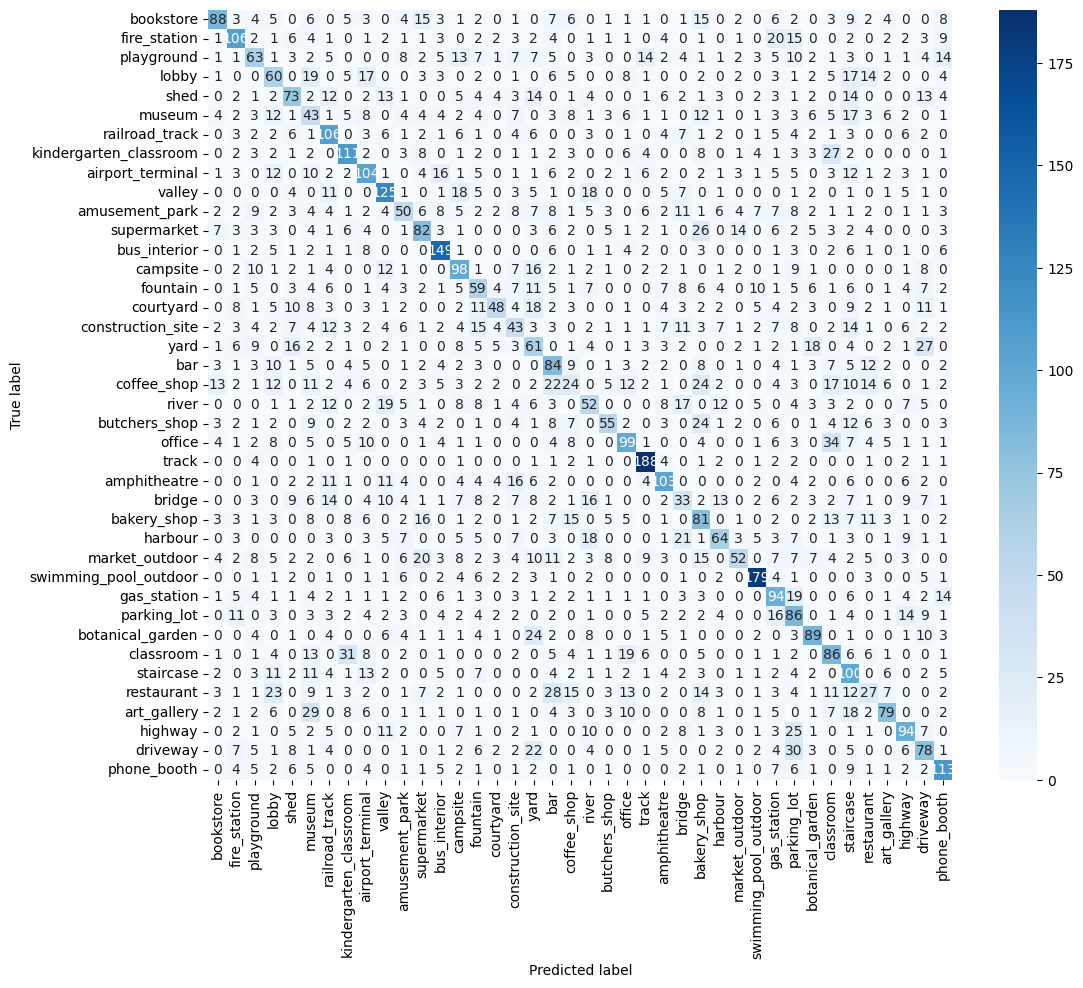

In [27]:
# Plot the confusion matrix
class_names = dataset.categories
plt.figure(figsize=(12,10))
sns.heatmap(conf_matrix.numpy(), xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 50 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Top-1 accuracy: 1.8349
Top-5 accuracy: 15.3670


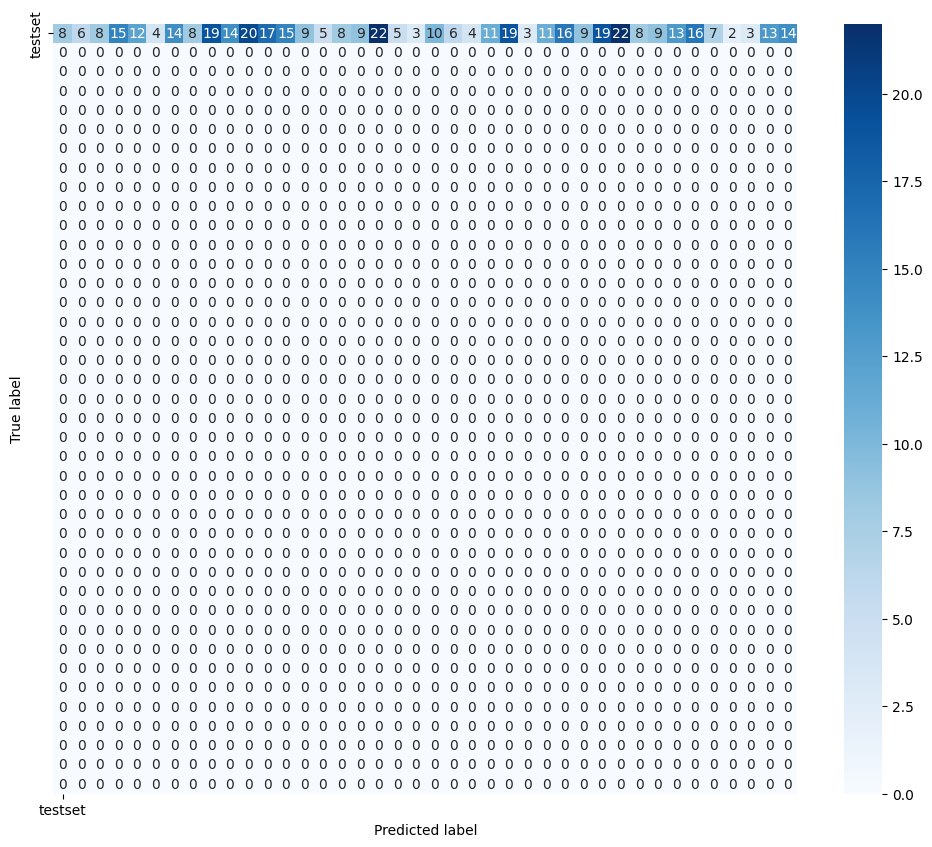

In [40]:
from torchvision import datasets

# Load the trained model
# Load the trained model
model = torchvision.models.resnet34(pretrained=False, num_classes=num_classes)

model.load_state_dict(torch.load('/content/drive/MyDrive/model2.pth'))
model = model.to(device)

# Define the batch size and the number of workers
batch_size = 32
num_workers = 50

# Load the test dataset
test_dataset = datasets.ImageFolder('/content/testset', transform=transform)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Set the model to evaluation mode
model.eval()

# Initialize counters for the top-1 and top-5 accuracies
top1_correct = 0
top5_correct = 0
total = 0

# Initialize the confusion matrix
conf_matrix = torch.zeros(num_classes, num_classes)

# Iterate over the test set
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)

        # Update the top-1 and top-5 accuracy counters
        top1_correct += torch.sum(preds == labels.data)
        for i in range(labels.size(0)):
            if labels[i] in top5_preds[i]:
                top5_correct += 1

        # Update the confusion matrix
        conf_matrix += confusion_matrix(labels.cpu(), preds.cpu(), labels=list(range(num_classes)))

        total += labels.size(0)

# Calculate the top-1 and top-5 accuracy
top1_acc = float(top1_correct) / total * 100
top5_acc = float(top5_correct) / total * 100

print('Top-1 accuracy: {:.4f}'.format(top1_acc))
print('Top-5 accuracy: {:.4f}'.format(top5_acc))

# Plot the confusion matrix
class_names = test_dataset.classes
plt.figure(figsize=(12,10))
sns.heatmap(conf_matrix.numpy(), xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [35]:
from torchvision import datasets
# Define the batch size and the number of workers
batch_size = 32
num_workers = 50

# Load the test dataset
test_dataset = datasets.ImageFolder('/content/testset', transform=transform)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 50 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing on the new generated dataset

Top-1 accuracy: 2.2936
Top-5 accuracy: 13.7615


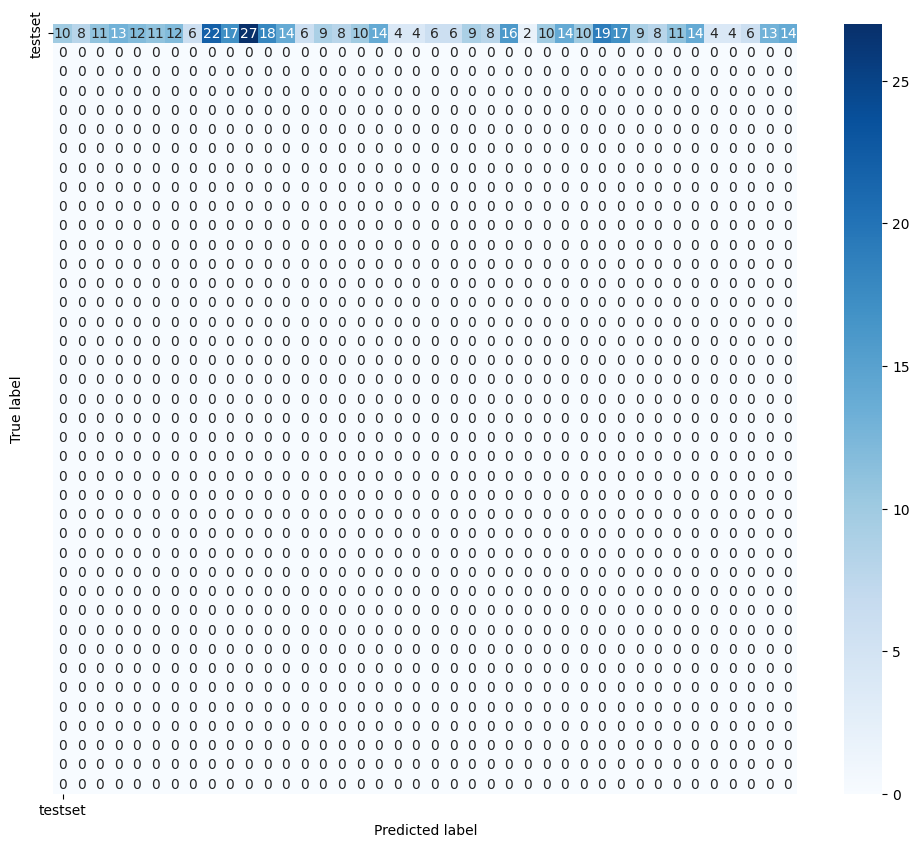

In [36]:
# load the trained model
model.load_state_dict(torch.load('/content/drive/MyDrive/model2.pth'))
# Set the model to evaluation mode
model.eval()

# Initialize counters for the top-1 and top-5 accuracies
top1_correct = 0
top5_correct = 0
total = 0

# Initialize the confusion matrix
conf_matrix = torch.zeros(num_classes, num_classes)

# Iterate over the test set
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)

        # Update the top-1 and top-5 accuracy counters
        top1_correct += torch.sum(preds == labels.data)
        for i in range(labels.size(0)):
            if labels[i] in top5_preds[i]:
                top5_correct += 1

        # Update the confusion matrix
        conf_matrix += confusion_matrix(labels.cpu(), preds.cpu(), labels=list(range(num_classes)))

        total += labels.size(0)

# Calculate the top-1 and top-5 accuracy
top1_acc = float(top1_correct) / total * 100
top5_acc = float(top5_correct) / total * 100

print('Top-1 accuracy: {:.4f}'.format(top1_acc))
print('Top-5 accuracy: {:.4f}'.format(top5_acc))

# Plot the confusion matrix
class_names = test_dataset.classes
plt.figure(figsize=(12,10))
sns.heatmap(conf_matrix.numpy(), xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
